Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import itertools
from sklearn.metrics import confusion_matrix



In [2]:
%run "visualizations.ipynb"

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for training.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU for training.")

Using GPU for training.


Making Dataset

In [4]:
torch.manual_seed(0)

data_path = "..\Data"
data = torchvision.datasets.ImageFolder(data_path, transform=torchvision.transforms.ToTensor())

In [5]:
NUM_CLASSES = len(os.listdir(data_path))
print(f"Identified {NUM_CLASSES} classes...")

class_name = os.listdir(data_path)
print(class_name)

Identified 4 classes...
['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


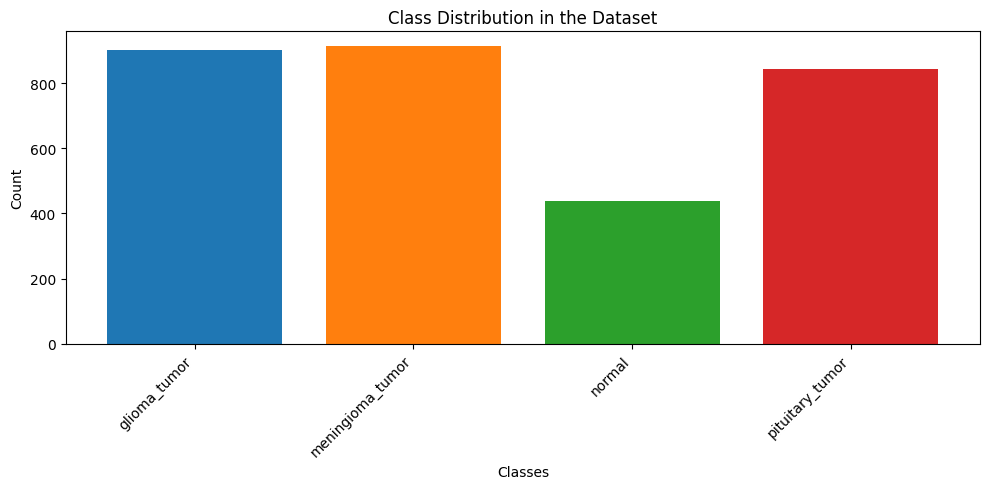

In [6]:

labels = [label for _, label in data]
label_counts = np.bincount(labels)
class_names = [folder_name for folder_name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder_name))]

plt.figure(figsize=(10, 5))
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.bar(class_names, label_counts[:len(class_names)], color=bar_colors)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution in the Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Split as a train and testing set:

In [7]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_size = int(train_ratio * len(data))
val_size = int(val_ratio * len(data))
test_size = len(data) - (train_size + val_size)

train_set, val_set, test_set = torch.utils.data.random_split(data, [train_size, val_size, test_size])
print('Data loaded and split into training, valadation and testing datasets')


Data loaded and split into training, valadation and testing datasets


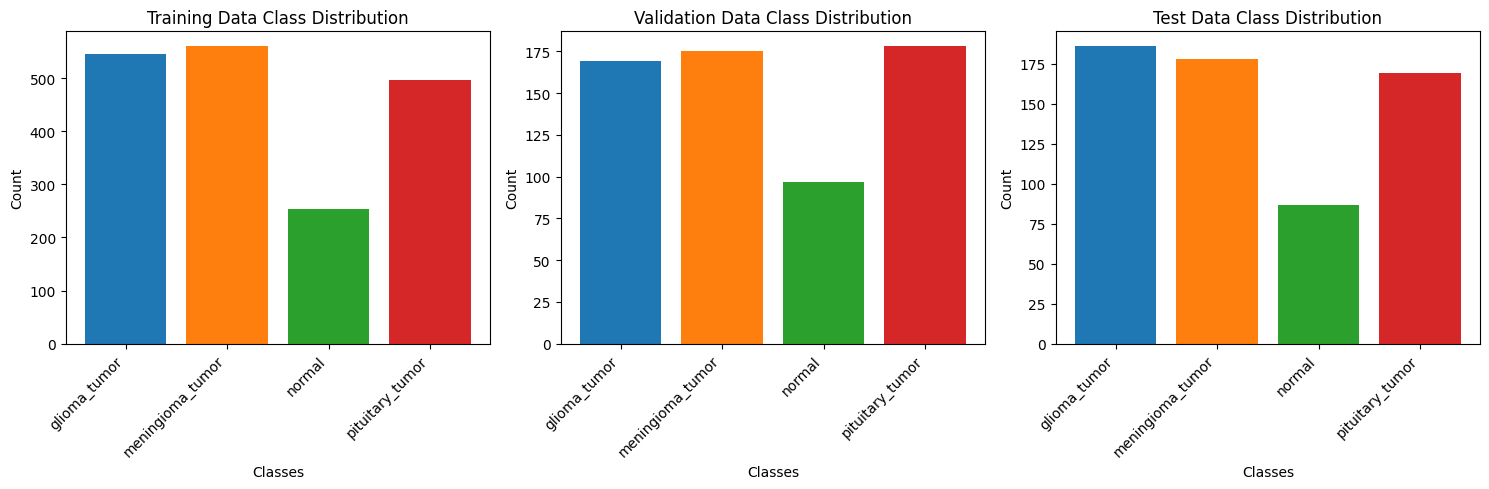

In [8]:
train_labels = [label for _, label in train_set]
val_labels = [label for _, label in val_set]
test_labels = [label for _, label in test_set]



train_label_counts = np.bincount(train_labels)
val_label_counts = np.bincount(val_labels)
test_label_counts = np.bincount(test_labels)

bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(class_names, train_label_counts[:len(class_names)], color=bar_colors)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Training Data Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.bar(class_names, val_label_counts[:len(class_names)], color=bar_colors)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Validation Data Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.bar(class_names, test_label_counts[:len(class_names)], color=bar_colors)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Test Data Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

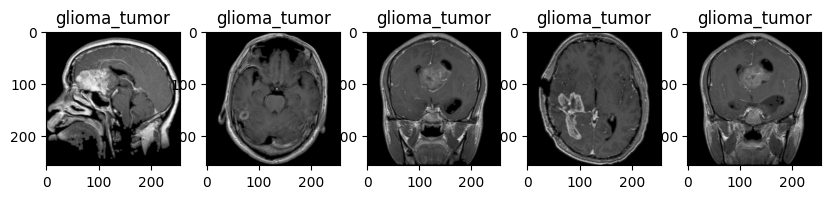

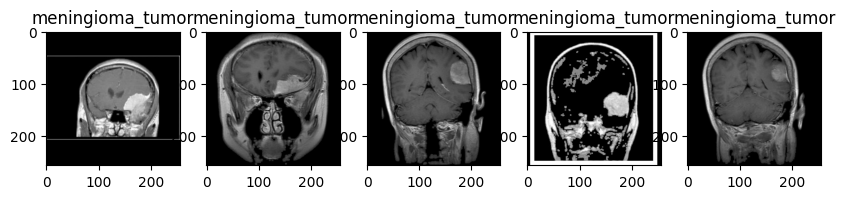

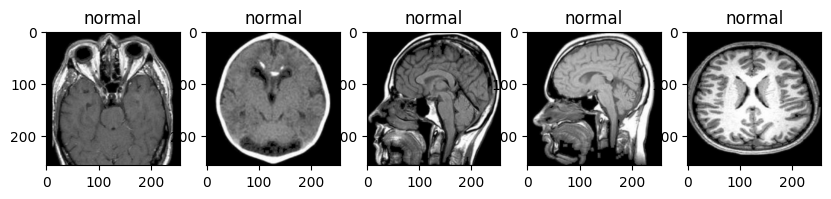

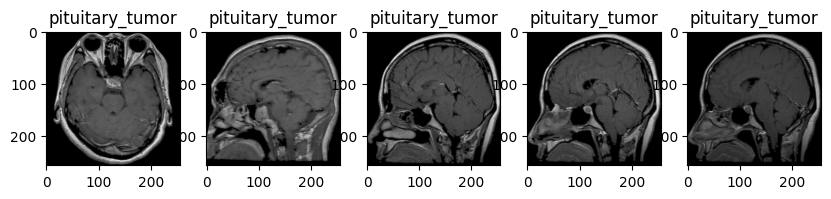

In [9]:

batch_size = 32  
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

directory=os.listdir(data_path)
for each in directory:
    plt.figure(figsize=(10, 10))
    currentFolder = data_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = data_path + '/' + each + "/" + file
        img=mpimg.imread(fullpath)
        ax=plt.subplot(1,5,i+1)
        ax.set_title(each)
        plt.imshow(img)

Training and Evaluation Code:


In [10]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.argmax(1).cpu().numpy())

    return total_loss / len(train_loader), total_correct / len(train_loader.dataset), all_labels, all_preds

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset), all_labels, all_preds




Basic Model

In [11]:
class MRI_CNN(nn.Module):
    def __init__(self):
        super(MRI_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 61 * 61, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



Model Testing:

In [12]:
model = MRI_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs=10

from tqdm import tqdm

# Create a tqdm progress bar
for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
    train_loss, train_accuracy, train_labels, train_preds = train(model, train_loader=train_loader,optimizer=optimizer, criterion=criterion, device=device)
    val_loss, val_accuracy, val_labels, val_preds = evaluate(model, val_loader, criterion= criterion, device=device)

    tqdm.write(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Train Accuracy: {train_accuracy * 100:.2f}% "
        f"Validation Loss: {val_loss:.4f} "
        f"Validation Accuracy: {val_accuracy * 100:.2f}%"
    )




Training:  10%|█         | 1/10 [00:08<01:17,  8.56s/epoch]

Epoch [1/10] Train Loss: 1.3157 Train Accuracy: 40.60% Validation Loss: 1.3597 Validation Accuracy: 41.52%


Training:  20%|██        | 2/10 [00:14<00:55,  6.97s/epoch]

Epoch [2/10] Train Loss: 0.9977 Train Accuracy: 58.64% Validation Loss: 0.8704 Validation Accuracy: 63.49%


Training:  30%|███       | 3/10 [00:20<00:45,  6.49s/epoch]

Epoch [3/10] Train Loss: 0.7373 Train Accuracy: 70.27% Validation Loss: 0.7369 Validation Accuracy: 70.60%


Training:  40%|████      | 4/10 [00:26<00:37,  6.26s/epoch]

Epoch [4/10] Train Loss: 0.5032 Train Accuracy: 79.70% Validation Loss: 0.9056 Validation Accuracy: 58.80%


Training:  50%|█████     | 5/10 [00:32<00:30,  6.14s/epoch]

Epoch [5/10] Train Loss: 0.3334 Train Accuracy: 86.65% Validation Loss: 0.7085 Validation Accuracy: 78.19%


Training:  60%|██████    | 6/10 [00:38<00:24,  6.06s/epoch]

Epoch [6/10] Train Loss: 0.1540 Train Accuracy: 95.10% Validation Loss: 0.8263 Validation Accuracy: 77.38%


Training:  70%|███████   | 7/10 [00:44<00:18,  6.02s/epoch]

Epoch [7/10] Train Loss: 0.1159 Train Accuracy: 96.28% Validation Loss: 0.8096 Validation Accuracy: 79.00%


Training:  80%|████████  | 8/10 [00:49<00:11,  6.00s/epoch]

Epoch [8/10] Train Loss: 0.0745 Train Accuracy: 97.47% Validation Loss: 0.9615 Validation Accuracy: 76.74%


Training:  90%|█████████ | 9/10 [00:55<00:05,  5.99s/epoch]

Epoch [9/10] Train Loss: 0.0682 Train Accuracy: 97.74% Validation Loss: 1.1735 Validation Accuracy: 76.90%


Training: 100%|██████████| 10/10 [01:01<00:00,  6.19s/epoch]

Epoch [10/10] Train Loss: 0.0221 Train Accuracy: 99.25% Validation Loss: 1.0868 Validation Accuracy: 79.32%


In [13]:
# Create a tqdm progress bar for testing
import time


test_losses = []
test_accuracies = []
for epoch in tqdm(range(epochs), desc="Testing", unit="epoch"):
    start_time = time.time()  # Record the start time
    test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, criterion=criterion, device=device)
    end_time = time.time()  # Record the end time

    epoch_time = end_time - start_time  # Calculate the time for the current epoch

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    tqdm.write(
        f"Testing Epoch [{epoch + 1}/{epochs}] "
        f"Test Loss: {test_loss:.4f} "
        f"Test Accuracy: {test_accuracy * 100:.2f}% "
        f"Time per Epoch: {epoch_time:.2f} seconds"
    )

# Print the average test loss and accuracy
avg_test_loss = sum(test_losses) / len(test_losses)
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Average Test Accuracy: {avg_test_accuracy * 100:.2f}%")

Testing:  10%|█         | 1/10 [00:00<00:07,  1.25epoch/s]

Testing Epoch [1/10] Test Loss: 1.1562 Test Accuracy: 77.74% Time per Epoch: 0.80 seconds


Testing:  20%|██        | 2/10 [00:01<00:06,  1.24epoch/s]

Testing Epoch [2/10] Test Loss: 1.1921 Test Accuracy: 77.74% Time per Epoch: 0.80 seconds


Testing:  30%|███       | 3/10 [00:02<00:05,  1.24epoch/s]

Testing Epoch [3/10] Test Loss: 1.2068 Test Accuracy: 77.74% Time per Epoch: 0.80 seconds


Testing:  40%|████      | 4/10 [00:03<00:04,  1.23epoch/s]

Testing Epoch [4/10] Test Loss: 1.1632 Test Accuracy: 77.74% Time per Epoch: 0.83 seconds


Testing:  50%|█████     | 5/10 [00:04<00:04,  1.23epoch/s]

Testing Epoch [5/10] Test Loss: 1.1559 Test Accuracy: 77.74% Time per Epoch: 0.80 seconds


Testing:  60%|██████    | 6/10 [00:04<00:03,  1.21epoch/s]

Testing Epoch [6/10] Test Loss: 1.1707 Test Accuracy: 77.74% Time per Epoch: 0.86 seconds


Testing:  70%|███████   | 7/10 [00:05<00:02,  1.21epoch/s]

Testing Epoch [7/10] Test Loss: 1.1542 Test Accuracy: 77.74% Time per Epoch: 0.83 seconds


Testing:  80%|████████  | 8/10 [00:06<00:01,  1.21epoch/s]

Testing Epoch [8/10] Test Loss: 1.1564 Test Accuracy: 77.74% Time per Epoch: 0.81 seconds


Testing:  90%|█████████ | 9/10 [00:07<00:00,  1.21epoch/s]

Testing Epoch [9/10] Test Loss: 1.1891 Test Accuracy: 77.74% Time per Epoch: 0.82 seconds


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.22epoch/s]

Testing Epoch [10/10] Test Loss: 1.2183 Test Accuracy: 77.74% Time per Epoch: 0.79 seconds
Average Test Loss: 1.1763
Average Test Accuracy: 77.74%


Model Classification:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       546
           1       0.99      0.99      0.99       560
           2       1.00      1.00      1.00       254
           3       1.00      1.00      1.00       497

    accuracy                           0.99      1857
   macro avg       0.99      0.99      0.99      1857
weighted avg       0.99      0.99      0.99      1857

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       169
           1       0.71      0.75      0.73       175
           2       0.93      0.65      0.76        97
           3       0.86      0.95      0.90       178

    accuracy                           0.79       619
   macro avg       0.81      0.78      0.79       619
weighted avg       0.80      0.79      0.79       619

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       186
           1       0.

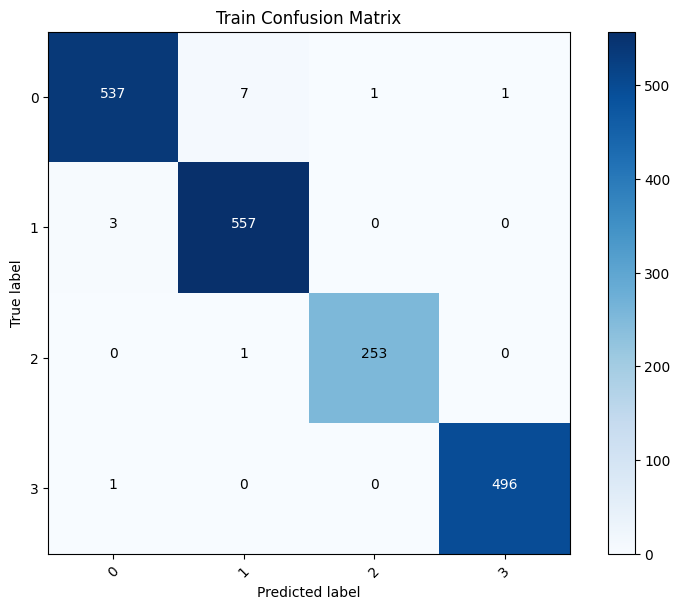

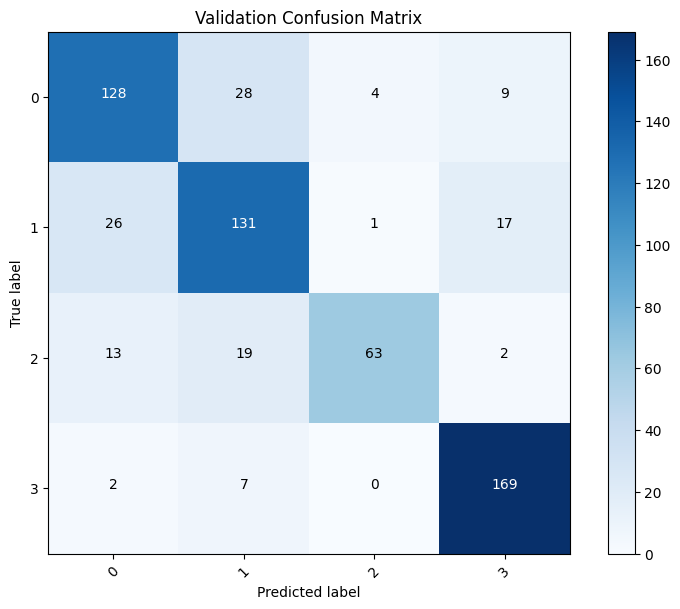

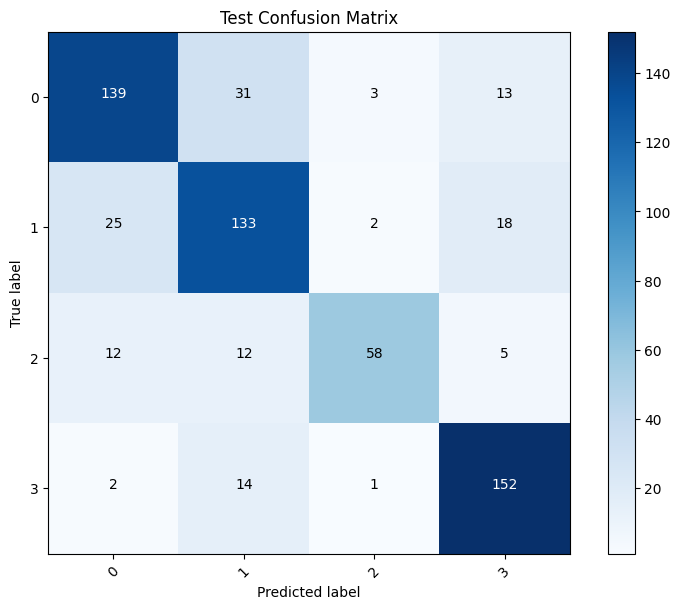

In [17]:
# Calculate confusion matrix
from sklearn.metrics import classification_report


confusion_train = confusion_matrix(train_labels, train_preds)
confusion_val = confusion_matrix(val_labels, val_preds)
confusion_test = confusion_matrix(test_labels, test_preds)

print(classification_report(train_labels, train_preds))
print(classification_report(val_labels, val_preds))
print(classification_report(test_labels, test_preds))

class_names = [str(i) for i in range(NUM_CLASSES)]  # Update with your class names
plot_confusion_matrix(confusion_train, class_names, title='Train Confusion Matrix')
plot_confusion_matrix(confusion_val, class_names, title='Validation Confusion Matrix')
plot_confusion_matrix(confusion_test, class_names, title='Test Confusion Matrix')



plt.show()

Better Model Testing and Classification: